In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import nibabel as nib
import os
import traceback

# Pustaka khusus untuk E2CNN
from e2cnn import gspaces
import e2cnn.nn as enn

In [ ]:
# Dataset untuk memuat slice 2D tengah dari dataset BraTS2020. 
# Setiap item mengembalikan 4 channel MRI (flair, t1, t1ce, t2) dan mask segmentasinya.
class BraTSDataset2D(Dataset):
    def __init__(self, data_dir):
        self.base_path = os.path.join(data_dir, 'MICCAI_BraTS2020_TrainingData')
        if not os.path.isdir(self.base_path):
            raise FileNotFoundError(f"Direktori tidak ditemukan di: '{self.base_path}'")
        self.patient_dirs = [p for p in os.listdir(self.base_path) if os.path.isdir(os.path.join(self.base_path, p))]

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        patient_dir_name = self.patient_dirs[idx]
        patient_path = os.path.join(self.base_path, patient_dir_name)

        # Path untuk setiap modalitas citra
        flair_path = os.path.join(patient_path, f"{patient_dir_name}_flair.nii")
        t1_path = os.path.join(patient_path, f"{patient_dir_name}_t1.nii")
        t1ce_path = os.path.join(patient_path, f"{patient_dir_name}_t1ce.nii")
        t2_path = os.path.join(patient_path, f"{patient_dir_name}_t2.nii")
        seg_path = os.path.join(patient_path, f"{patient_dir_name}_seg.nii")

        # Memuat data citra
        flair_img = nib.load(flair_path).get_fdata()
        t1_img = nib.load(t1_path).get_fdata()
        t1ce_img = nib.load(t1ce_path).get_fdata()
        t2_img = nib.load(t2_path).get_fdata()
        seg_mask = nib.load(seg_path).get_fdata()

        # Mengambil slice tengah dari volume 3D
        mid_slice_idx = flair_img.shape[2] // 2
        image_stack = np.stack([
            flair_img[:, :, mid_slice_idx],
            t1_img[:, :, mid_slice_idx],
            t1ce_img[:, :, mid_slice_idx],
            t2_img[:, :, mid_slice_idx]
        ], axis=0)
        seg_slice = seg_mask[:, :, mid_slice_idx]

        # # Konversi ke tensor PyTorch
        image_tensor = torch.tensor(image_stack, dtype=torch.float32)
        label_tensor = torch.tensor(seg_slice, dtype=torch.long)
        label_tensor[label_tensor == 4] = 3

    #    # Konversi ke tensor PyTorch
    #     image_tensor = torch.tensor(image_stack, dtype=torch.float32)
    #     label_tensor = torch.tensor(seg_slice, dtype=torch.long)
        
    #     # Ganti label 4 menjadi 3
    #     mask = (label_tensor == 4)

    #     # DEBUG: Periksa tipe data mask. Seharusnya torch.bool.
    #     if mask.dtype != torch.bool:
    #         # Jika tipe datanya salah, cetak pesan dan konversi secara paksa.
    #         # Ini adalah langkah pengaman untuk menjamin kompatibilitas.
    #         print(f"Peringatan: Tipe data mask adalah {mask.dtype}, bukan torch.bool. Mengonversi secara paksa.")
    #         mask = mask.to(torch.bool)

    #     label_tensor.masked_fill_(mask, 3)
        
        # Normalisasi sederhana per channel
        for i in range(image_tensor.shape[0]):
            max_val = torch.max(image_tensor[i])
            if max_val > 0:
                image_tensor[i] = image_tensor[i] / max_val

        return image_tensor, label_tensor

In [3]:
class DoubleEquivariantConv(nn.Module):
    """Blok konvolusi ganda yang equivariant."""
    def __init__(self, in_type, out_type, mid_type=None):
        super().__init__()
        if not mid_type:
            mid_type = out_type
        self.double_conv = enn.SequentialModule(
            enn.R2Conv(in_type, mid_type, kernel_size=3, padding=1, bias=False),
            enn.InnerBatchNorm(mid_type),
            enn.ReLU(mid_type, inplace=True),
            enn.R2Conv(mid_type, out_type, kernel_size=3, padding=1, bias=False),
            enn.InnerBatchNorm(out_type),
            enn.ReLU(out_type, inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Blok downsampling menggunakan MaxPool diikuti DoubleEquivariantConv."""
    def __init__(self, in_type, out_type):
        super().__init__()
        self.pool = enn.PointwiseMaxPool(in_type, kernel_size=2)
        self.conv = DoubleEquivariantConv(in_type, out_type)
    def forward(self, x):
        x = self.pool(x)
        return self.conv(x)

class Up(nn.Module):
    """Blok upsampling diikuti penggabungan skip connection dan DoubleEquivariantConv."""
    def __init__(self, in_type, out_type):
        super().__init__()
        self.up = enn.R2Upsampling(in_type, scale_factor=2, mode='bilinear', align_corners=True)
        # Tipe input untuk konvolusi adalah gabungan dari tensor setelah upsampling dan tensor dari skip connection
        self.conv = DoubleEquivariantConv(in_type + out_type, out_type)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Menggabungkan tensor dari skip connection (x2) dan tensor yang di-upsample (x1)
        x = enn.tensor_directsum([x2, x1])
        return self.conv(x)

class OutConv(nn.Module):
    """Konvolusi 1x1 di akhir untuk memetakan fitur ke jumlah kelas output."""
    def __init__(self, in_type, n_classes):
        super().__init__()
        gspace = in_type.gspace
        # Tipe output adalah trivial representation, karena output segmentasi harus invarian terhadap rotasi
        out_type = enn.FieldType(gspace, n_classes * [gspace.trivial_repr])
        self.conv = enn.R2Conv(in_type, out_type, kernel_size=1)
    def forward(self, x):
        return self.conv(x)
    
class SE2_CNNET(nn.Module):
    """
    Arsitektur U-Net Equivariant SE(2) untuk segmentasi.
    N: Jumlah rotasi diskrit yang akan dipertimbangkan (misal, N=8 untuk rotasi kelipatan 45 derajat).
    base_channels: Jumlah channel dasar pada lapisan pertama.
    """
    def __init__(self, n_channels, n_classes, N=8, base_channels=24):
        super().__init__()
        self.r2_act = gspaces.Rot2dOnR2(N=N)
        c = base_channels

        # Mendefinisikan tipe field untuk setiap level kedalaman U-Net
        self.feat_type_in = enn.FieldType(self.r2_act, n_channels * [self.r2_act.trivial_repr])
        self.feat_type_1 = enn.FieldType(self.r2_act, c * [self.r2_act.regular_repr])
        self.feat_type_2 = enn.FieldType(self.r2_act, (c*2) * [self.r2_act.regular_repr])
        self.feat_type_3 = enn.FieldType(self.r2_act, (c*4) * [self.r2_act.regular_repr])
        self.feat_type_4 = enn.FieldType(self.r2_act, (c*8) * [self.r2_act.regular_repr])
        self.feat_type_5 = enn.FieldType(self.r2_act, (c*16) * [self.r2_act.regular_repr])

        # Encoder Path
        self.inc = DoubleEquivariantConv(self.feat_type_in, self.feat_type_1)
        self.down1 = Down(self.feat_type_1, self.feat_type_2)
        self.down2 = Down(self.feat_type_2, self.feat_type_3)
        self.down3 = Down(self.feat_type_3, self.feat_type_4)
        self.down4 = Down(self.feat_type_4, self.feat_type_5)

        # Decoder Path
        self.up1 = Up(self.feat_type_5, self.feat_type_4)
        self.up2 = Up(self.feat_type_4, self.feat_type_3)
        self.up3 = Up(self.feat_type_3, self.feat_type_2)
        self.up4 = Up(self.feat_type_2, self.feat_type_1)

        # Output Layer
        self.outc = OutConv(self.feat_type_1, n_classes)

    def forward(self, x):
        # Konversi input tensor menjadi GeometricTensor
        x_geom = enn.GeometricTensor(x, self.feat_type_in)

        # Encoder
        x1 = self.inc(x_geom)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # Mengembalikan tensor biasa untuk dihitung loss-nya
        logits = self.outc(x).tensor
        return logits
    

In [4]:
def run_test():
    """
    Fungsi untuk menjalankan tes singkat pada dataset dan model.
    """
    try:
        print("Menjalankan uji coba model dan data loader...")
        DATA_DIRECTORY = r"./DataBrainSeg/BraTS2020_TrainingData"
        train_dataset = BraTSDataset2D(data_dir=DATA_DIRECTORY)
        single_image, _ = train_dataset[0]

        # device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
        device = 'cpu'
        print(device)

        model = SE2_CNNET(n_channels=4, n_classes=4).to(device)

        # Menambahkan dimensi batch
        input_tensor = single_image.unsqueeze(0).to(device)

        print(f"Menggunakan device: {device}")
        print(f"Bentuk input tensor: {input_tensor.shape}")

        model.eval()
        with torch.no_grad():
            output = model(input_tensor)

        print(f"Bentuk output tensor: {output.shape}")
        print("\nProses SE2-CNN selesai tanpa error.")

    except Exception as e:
        print(f"\nTerjadi error: {e}")
        traceback.print_exc()

run_test()

Menjalankan uji coba model dan data loader...
cpu


/Users/iganarendra/miniconda3/envs/py310/lib/python3.10/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  full_mask[mask] = norms.to(torch.uint8)



Terjadi error: masked_fill_ only supports boolean masks, but got mask with dtype unsigned char


Traceback (most recent call last):
  File "/var/folders/n3/m1s0yv350f31gh_47zx7g2gr0000gr/T/ipykernel_87998/1700810005.py", line 15, in run_test
    model = SE2_CNNET(n_channels=4, n_classes=4).to(device)
  File "/var/folders/n3/m1s0yv350f31gh_47zx7g2gr0000gr/T/ipykernel_87998/3592750231.py", line 85, in __init__
    self.outc = OutConv(self.feat_type_1, n_classes)
  File "/var/folders/n3/m1s0yv350f31gh_47zx7g2gr0000gr/T/ipykernel_87998/3592750231.py", line 48, in __init__
    self.conv = enn.R2Conv(in_type, out_type, kernel_size=1)
  File "/Users/iganarendra/miniconda3/envs/py310/lib/python3.10/site-packages/e2cnn/nn/modules/r2_conv/r2convolution.py", line 254, in __init__
    self._basisexpansion = BlocksBasisExpansion(in_type, out_type,
  File "/Users/iganarendra/miniconda3/envs/py310/lib/python3.10/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_blocks.py", line 77, in __init__
    block_expansion = block_basisexpansion(basis, points, basis_filter, recompute=recompute)
  File

# Check Arsitektur pipline Data -> Model SYNC

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm 

DATA_DIRECTORY = r"./DataBrainSeg/BraTS2020_TrainingData"
LEARNING_RATE = 1e-4
BATCH_SIZE = 4
EPOCHS = 10
VALIDATION_SPLIT = 0.15 # 15% data untuk validasi
NUM_CLASSES = 4 # ET, TC, WT, dan background 
INPUT_CHANNELS = 4

# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = 'cpu'
print(f"Device yang akan digunakan: {device}")


print("Mempersiapkan dataset...")
full_dataset = BraTSDataset2D(data_dir=DATA_DIRECTORY)

n_val = int(len(full_dataset) * VALIDATION_SPLIT)
n_train = len(full_dataset) - n_val
train_set, val_set = random_split(full_dataset, [n_train, n_val])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
print(f"Data siap: {len(train_set)} sampel training, {len(val_set)} sampel validasi.")

model = SE2_CNNET(n_channels=INPUT_CHANNELS, n_classes=NUM_CLASSES)

if torch.cuda.device_count() > 1:
    print(f"Menggunakan {torch.cuda.device_count()} GPU dengan DataParallel.")
    model = nn.DataParallel(model)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Device yang akan digunakan: cpu
Mempersiapkan dataset...
Data siap: 314 sampel training, 55 sampel validasi.


RuntimeError: masked_fill_ only supports boolean masks, but got mask with dtype unsigned char

In [ ]:
# for epoch in range(EPOCHS):
#     model.train()
#     running_loss = 0.0

#     pbar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]")
#     for images, labels in pbar_train:
#         images = images.to(device)
#         labels = labels.to(device)

#         outputs = model(images)
#         loss = criterion(outputs, labels)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         pbar_train.set_postfix({'loss': loss.item()})

#     avg_train_loss = running_loss / len(train_loader)

#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validasi]")
#         for images, labels in pbar_val:
#             images = images.to(device)
#             labels = labels.to(device)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()
#             pbar_val.set_postfix({'val_loss': loss.item()})

#     avg_val_loss = val_loss / len(val_loader)

#     print(f"Epoch {epoch+1}/{EPOCHS} -> Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

#     torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')

Epoch 1/1 [Training]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/1 [Validasi]: 100%|██████████| 14/14 [02:11<00:00,  9.36s/it, val_loss=0.313]


Epoch 1/1 -> Training Loss: 0.5418, Validation Loss: 0.2887


In [ ]:
import numpy as np # Diperlukan untuk float('inf')

patience = 6 
epochs_no_improve = 0
best_val_loss = float('inf') 
# Path untuk menyimpan model terbaik.
BEST_MODEL_PATH = '[1]best_model.pth'
EPOCHS = 30
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    pbar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]")
    for images, labels in pbar_train:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar_train.set_postfix({'loss': loss.item()})

    avg_train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validasi]")
        for images, labels in pbar_val:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            pbar_val.set_postfix({'val_loss': loss.item()})

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{EPOCHS} -> Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    
    if avg_val_loss < best_val_loss:
        print(f"Validation loss membaik ({best_val_loss:.4f} --> {avg_val_loss:.4f}). Menyimpan model ke {BEST_MODEL_PATH}")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
        }, BEST_MODEL_PATH)
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"Validation loss tidak membaik. Counter kesabaran: {epochs_no_improve}/{patience}")

    if epochs_no_improve >= patience:
        print(f"Early stopping! Tidak ada perbaikan selama {patience} epoch.")
        break 

Epoch 1/30 [Validasi]: 100%|██████████| 14/14 [03:54<00:00, 16.77s/it, val_loss=0.264]


Epoch 1/30 -> Training Loss: 0.2840, Validation Loss: 0.2639
Validation loss membaik (inf --> 0.2639). Menyimpan model ke [1]best_model.pth


Epoch 2/30 [Validasi]: 100%|██████████| 14/14 [03:08<00:00, 13.50s/it, val_loss=0.257]


Epoch 2/30 -> Training Loss: 0.2777, Validation Loss: 0.2584
Validation loss membaik (0.2639 --> 0.2584). Menyimpan model ke [1]best_model.pth


Epoch 3/30 [Training]:  28%|██▊       | 22/79 [14:47<38:19, 40.34s/it, loss=0.25] 


KeyboardInterrupt: 

# Kalau mau async training

In [ ]:
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = SE2_CNNET(n_channels=4, n_classes=NUM_CLASSES).to(DEVICE)
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# # Variabel untuk Melanjutkan Training ya kak 
# start_epoch = 2
# best_val_loss = float('inf')
# CHECKPOINT_PATH = BEST_MODEL_PATH

# if os.path.exists(CHECKPOINT_PATH):
#     print(f"Menemukan checkpoint. Memuat dari {CHECKPOINT_PATH}...")
#     checkpoint = torch.load(CHECKPOINT_PATH)
    
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     start_epoch = checkpoint['epoch'] + 1 
#     best_val_loss = checkpoint['best_val_loss']
#     print(f"Checkpoint berhasil dimuat. Melanjutkan dari epoch {start_epoch}.")
# else:
#     print("Tidak ada checkpoint ditemukan. Memulai training dari awal.")

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

MODEL_PATH = 'model_epoch_1.pth'
DATA_DIRECTORY = r"BraTS2020_TrainingData"
BATCH_SIZE = 8
NUM_CLASSES = 4 # 0: background, 1: class 1, 2: class 2, 3: class 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ingat, label 4 di data asli kita petakan ke 3
CLASS_LABELS = {
    0: "Background",
    1: "NCR/NET",  # Necrotic and non-enhancing tumor core
    2: "ED",       # Peritumoral edema
    3: "ET"        # GD-enhancing tumor (sebelumnya label 4)
}

#Load Model
print(f"Memuat model dari: {MODEL_PATH}")
model = SE2_CNNET(n_channels=4, n_classes=NUM_CLASSES)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)

# 3model disimpan dengan nn.DataParallel
if list(state_dict.keys())[0].startswith('module.'):
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # hapus `module.`
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
else:
    model.load_state_dict(state_dict)

model.to(DEVICE)
model.eval() 
print("Model berhasil dimuat.")

Memuat model dari: model_epoch_1.pth
Model berhasil dimuat.


In [ ]:
def calculate_dice_iou(preds, labels, num_classes, smooth=1e-6):
    """
    Menghitung Dice Coefficient dan IoU per kelas.
    - preds: Tensor prediksi setelah argmax, shape (N, H, W)
    - labels: Tensor ground truth, shape (N, H, W)
    - num_classes: Jumlah kelas
    """
    dice_scores = np.zeros(num_classes)
    iou_scores = np.zeros(num_classes)
    
    # CPU dan NumPy untuk perhitungan
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()

    for c in range(num_classes):
        pred_mask = (preds == c)
        true_mask = (labels == c)
        
        intersection = np.sum(pred_mask & true_mask)
        union = np.sum(pred_mask | true_mask)
        
        # Dice Score
        dice = (2. * intersection + smooth) / (np.sum(pred_mask) + np.sum(true_mask) + smooth)
        dice_scores[c] = dice
        
        # IoU Score
        iou = (intersection + smooth) / (union + smooth)
        iou_scores[c] = iou
        
    return dice_scores, iou_scores

def evaluate_model(model, loader, device, num_classes):
    """
    Fungsi utama untuk menjalankan loop evaluasi.
    """
    total_dice_scores = np.zeros(num_classes)
    total_iou_scores = np.zeros(num_classes)
    num_batches = 0
    
    with torch.no_grad(): # Skip calculation gradient on backprop
        pbar = tqdm(loader, desc="Mengevaluasi")
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)
   
            outputs = model(images)
            
            # logits menjadi prediksi kelas (0, 1, 2, atau 3)
            # torch.argmax => collect kelas dengan probabilitas tertinggi
            preds = torch.argmax(outputs, dim=1)
            
            dice, iou = calculate_dice_iou(preds, labels, num_classes)
            
            total_dice_scores += dice
            total_iou_scores += iou
            num_batches += 1
            
            # Tampilkan rata-rata sementara di progress bar
            mean_dice = np.mean(total_dice_scores / num_batches)
            pbar.set_postfix({'Mean Dice (avg)': f'{mean_dice:.4f}'})

    # Hitung rata-rata akhir
    avg_dice_scores = total_dice_scores / num_batches
    avg_iou_scores = total_iou_scores / num_batches
    
    return avg_dice_scores, avg_iou_scores


avg_dice, avg_iou = evaluate_model(model, val_loader, DEVICE, NUM_CLASSES)
    
print("\nHasil Evaluasi Performa")
print(f"{'Kelas':<20} | {'Dice Score':<15} | {'IoU (Jaccard)':<15}")
print("-" * 55)
for c in range(NUM_CLASSES):
    class_name = CLASS_LABELS.get(c, f"Kelas {c}")
    print(f"{class_name:<20} | {avg_dice[c]:<15.4f} | {avg_iou[c]:<15.4f}")
    
print("-" * 55)
print(f"{'Rata-rata (Mean)':<20} | {np.mean(avg_dice):<15.4f} | {np.mean(avg_iou):<15.4f}")
print("-" * 55)

Mengevaluasi: 100%|██████████| 14/14 [02:31<00:00, 10.85s/it, Mean Dice (avg)=0.5835]


Hasil Evaluasi Performa
Kelas                | Dice Score      | IoU (Jaccard)  
-------------------------------------------------------
Background           | 0.9940          | 0.9880         
NCR/NET              | 0.3201          | 0.2212         
ED                   | 0.5250          | 0.3679         
ET                   | 0.4947          | 0.3560         
-------------------------------------------------------
Rata-rata (Mean)     | 0.5835          | 0.4833         
-------------------------------------------------------


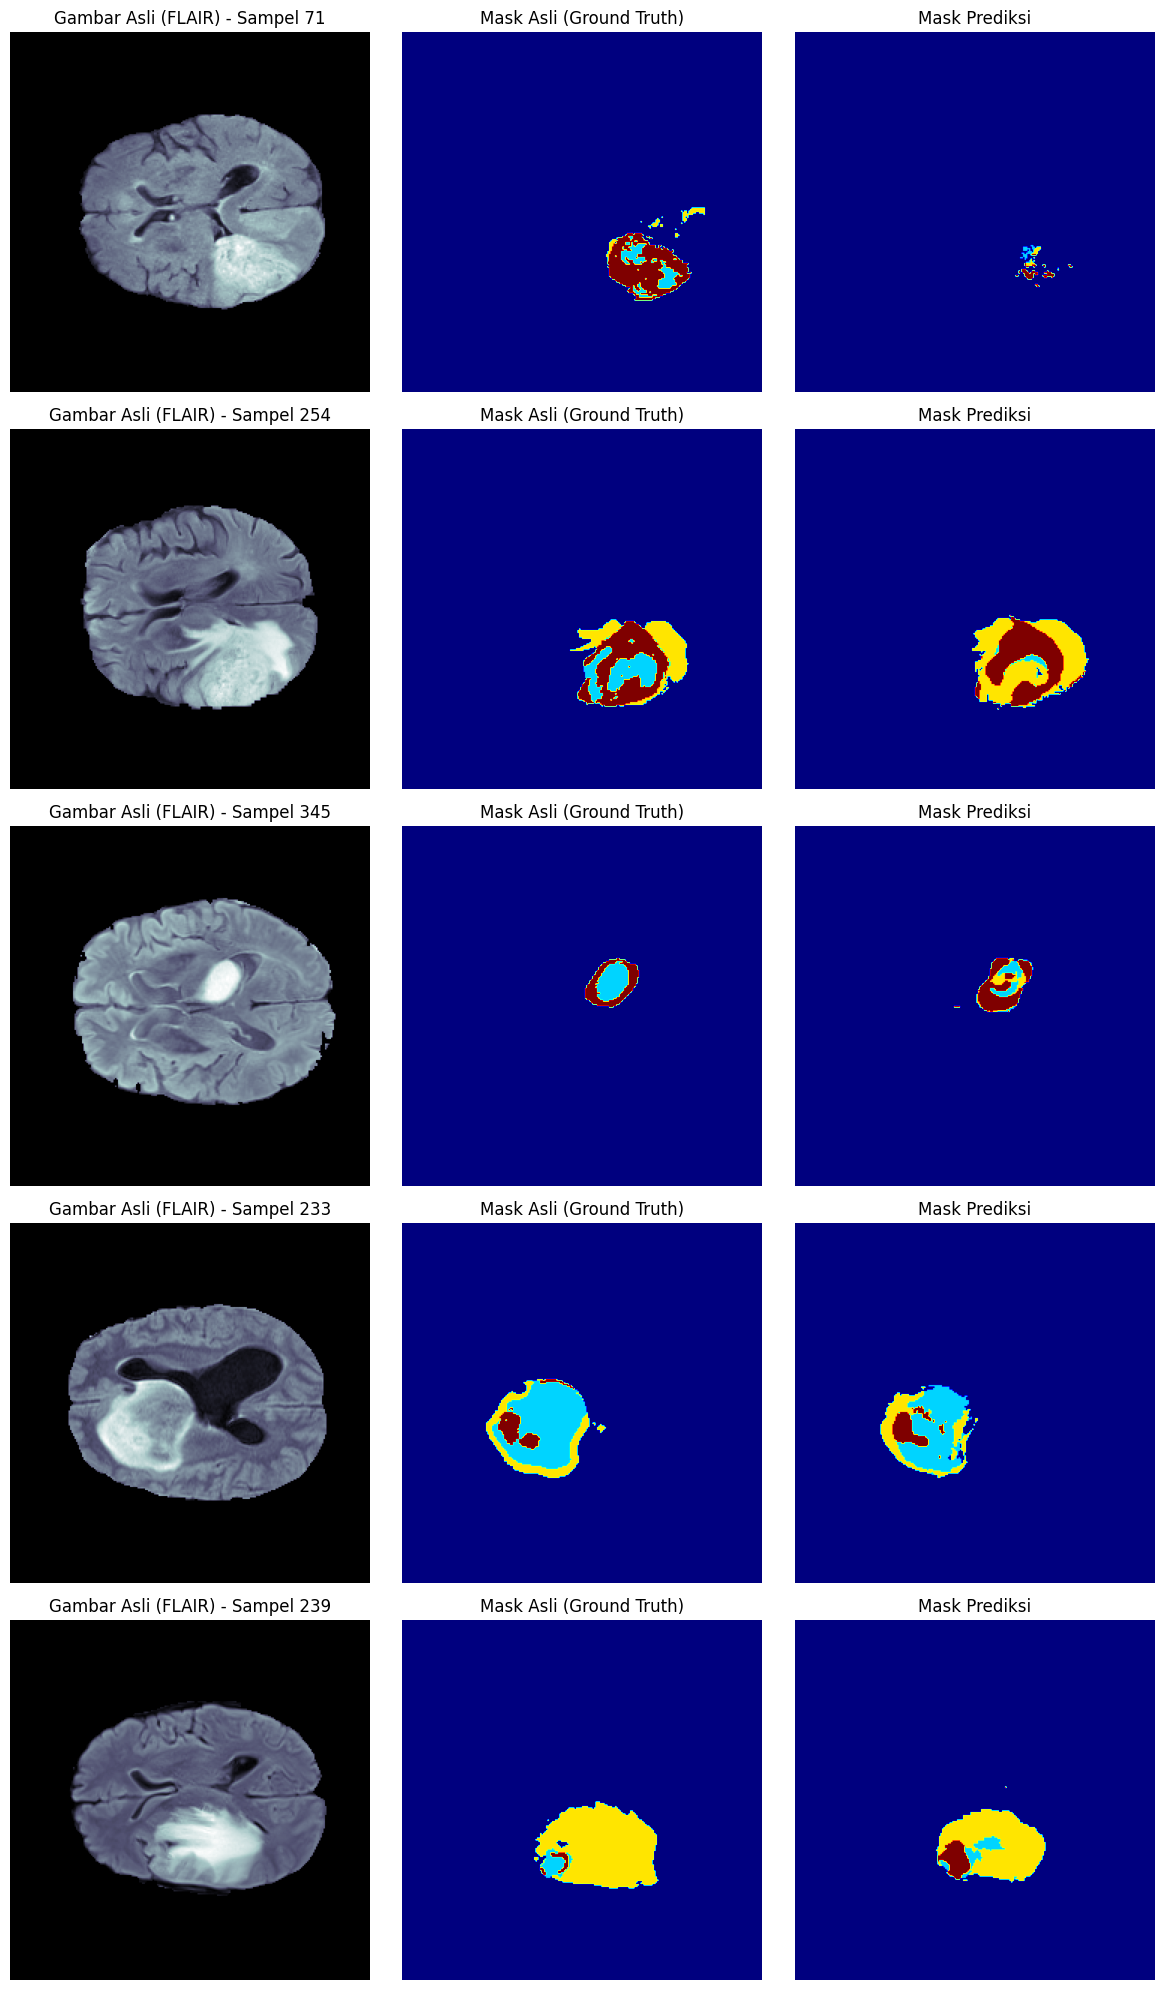

In [ ]:
def visualize_predictions(model, dataset, device, num_samples=5):
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4))
    
    # Ambil sampel secara acak
    indices = np.random.choice(range(len(dataset)), num_samples, replace=False)
    
    model.eval()
    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, label = dataset[idx]
            
            # Tambahkan dimensi batch dan kirim ke device
            input_tensor = image.unsqueeze(0).to(device)
            
            # Prediksi
            output = model(input_tensor)
            pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
            
            # Siapkan untuk plotting
            original_image = image[0].numpy() # Tampilkan channel pertama (FLAIR)
            true_mask = label.numpy()
            
            # Plotting
            axes[i, 0].imshow(original_image, cmap='bone')
            axes[i, 0].set_title(f"Gambar Asli (FLAIR) - Sampel {idx}")
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(true_mask, cmap='jet')
            axes[i, 1].set_title("Mask Asli (Ground Truth)")
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(pred_mask, cmap='jet')
            axes[i, 2].set_title("Mask Prediksi")
            axes[i, 2].axis('off')
            
    plt.tight_layout()
    plt.show()


visualize_predictions(model, full_dataset, DEVICE)